In [1]:
from IPython.display import display, HTML

display(HTML(r"""
<style>
/* JupyterLab 4.x: center the notebook area */
.jp-NotebookPanel-notebook,
.jp-NotebookPanel .jp-Notebook {
  width: 85% !important;
  max-width: 1100px !important;
  margin: 0 auto !important;
}

/* Make wide outputs scroll instead of breaking the layout */
.jp-OutputArea-output {
  overflow-x: auto !important;
}
</style>
"""))

%config InlineBackend.figure_format = "svg"
print("Centered JupyterLab notebook + SVG inline figures.")

Centered JupyterLab notebook + SVG inline figures.


# Lecture-02: Statistical language models

- **CS40008.01, NLP and LLMs**
- **Date:** 03/12/2026
- **Lecturer:** Baojian Zhou
- **Institution:** The School of Data Science, Fudan University

<a id="0"></a> <br>
## Table of Contents
- [1. Understand data distribution](#1)
  - [1.1 KL divergence](#11)
  - [1.2 Log probability of sentences](#12)
- [1. Build Ngram-LMs](#2)
  - [1.1 Load wikitext-103](#21)
  - [1.2 Sentence tokenization for wikitext](#22)
  - [1.3 Training Ngram via kenlm](#23)
  - [1.4 Calculate the perplexity](#24)
  - [1.5 Generate sentences](#25)

<a id="1"></a>
## 1. Understand data distribution

- **Motivation: assign probabilities to sentences**
  - **Speech Recognition:** In the task of speech recongnition, we should need to know which sentence is more likely than others. Exmplore, the sentence `It's hard to recognize speech` is more likely the corrent speech than the sentence `It's hard to recognize speech`. That is, a good model should give
    
    $P_\theta($ `It's hard to recognize speech` $) > P_\theta($ `It's hard to wreck a nice beach` $)$
  - **Machine Translation (MT):** Given the source sentence, `他向记者介绍了主要内容` that we want to tranlate into English, there are some potential candidates
    - $S_1$ = He briefed reporters on the main contents of the statement
    - $S_2$ = He introduced reporters to the main contents of the statement
    - $S_3$ = He briefed to reporters the main contents of the statement
    - $S_4$ = He to reporters introduced main content
    A good MT model should have $P_\theta(S_1 )> P_\theta(S_2) \approx P_\theta(S_3) > P_\theta(S_4)$
  - **Spell Correction:** Consider the testing sentence `The office is about fifteen minuets from my house`, where `minuets` is misspelled. A good model should have
    
    $P_\theta($ `about fifteen minutes from` $)$ $>P_\theta($ `about fifteen minuets from` $)$

<a id="11"></a>
### 1.1 KL divergence

- **Model distribution approximate true distribution via KL divergence**
  
In general, LLMs approximate an unknown distribution $p_{\text{data}}$, which is a distribution over token sequences:
      $$\mathbf{w}_{1:n}=(w_1,\ldots,w_n), \qquad \mathbf{w}_{1:n}\sim p_{\text{data}}(\cdot),$$
      where $p_{\text{data}}$ is unknown. We only observe a corpus (samples):
      $$\mathcal{D}=\{\mathbf{w}^{(i)}\}_{i=1}^{N}, \qquad \mathbf{w}^{(i)} \overset{\text{i.i.d.}}{\sim} p_{\text{data}}(\cdot).$$
    </div>
We train a model distribution (LLMs) $p_\theta(\mathbf{w})$ so that
      $$p_\theta(\mathbf{w}) \approx p_{\text{data}}(\mathbf{w}).$$
Under $p_\theta$, sequences that look like real language should get **higher** probability than corrupted/random ones:
      $$p_\theta(\text{“natural sentence”})\;>\;p_\theta(\text{“random sentence”}).$$

- **Next, we will see how to use KL divergence to measure difference between $p_{\text{data}}$ and $p_\theta$**

**Training objective: make $p_\theta \approx p_{\text{data}}:$** Ideal goal (distribution matching) is to make $p_\theta \approx p_{\text{data}}.$ To do this, one principled way is to find a $\theta$ such that the [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) is minimized, i.e.,
      $$\theta^\star=\arg\min_\theta \mathrm{KL}\big(p_{\text{data}} \,\|\, p_\theta\big).$$
This is equivalent to maximizing expected log-likelihood:
      $$\arg\min_\theta \mathrm{KL}(p_{\text{data}}\|p_\theta)
      \;\Longleftrightarrow\;
      \arg\max_\theta \mathbb{E}_{\mathbf{w} \sim p_{\text{data}}}\big[\log p_\theta(\mathbf{w})\big].$$
Since $p_{\text{data}}$ is unknown, use the dataset $\{\mathbf{w}^{(i)}\}_{i=1}^N$ to approximate the expectation:
      $$\max_\theta \frac{1}{N}\sum_{i=1}^N \log p_\theta (\mathbf{w}^{(i)}).$$

<div style="
  background: #f2f2f2;
  border: 1px solid #d9d9d9;
  border-left: 6px solid #9e9e9e;
  padding: 16px 18px;
  border-radius: 12px;
  font-size: 18px;
  line-height: 1.35;
">

  <div style="font-weight: 800; font-size: 20px; margin-bottom: 10px;">
    Theorem (KL minimization ⇔ maximum expected log-likelihood)
  </div>
  <div style="margin-bottom: 10px;">
    Let \(p_{\text{data}}(\mathbf{w})\) be fixed and let \(p_\theta(\mathbf{w})\) be a model family.
    Assume \(\mathbb{E}_{p_{\text{data}}}[|\log p_\theta(\mathbf{w})|] < \infty\) and
    \(p_\theta(\mathbf{w})>0\) whenever \(p_{\text{data}}(\mathbf{w})>0\).
    Then
  </div>

  <div style="margin: 10px 0;">
    \[
      \theta^\star \in \arg\min_{\theta} \mathrm{KL}\!\left(p_{\text{data}}\;\|\;p_\theta\right)
      \quad\Longleftrightarrow\quad
      \theta^\star \in \arg\max_{\theta}\mathbb{E}_{\mathbf{w}\sim p_{\text{data}}}\!\left[\log p_\theta(\mathbf{w})\right].
    \]
  </div>

  <details style="margin-top: 10px;">
    <summary style="cursor: pointer; font-weight: 700;">Proof (click to expand)</summary>
    <div style="margin-top: 10px;">
      By definition,
      \[
        \mathrm{KL}(p_{\text{data}}\|p_\theta)
        = \mathbb{E}_{p_{\text{data}}}\!\left[\log\frac{p_{\text{data}}(\mathbf{w})}{p_\theta(\mathbf{w})}\right]
        = \mathbb{E}_{p_{\text{data}}}[\log p_{\text{data}}(\mathbf{w})]
          - \mathbb{E}_{p_{\text{data}}}[\log p_\theta(\mathbf{w})].
      \]
      The term \(\mathbb{E}_{p_{\text{data}}}[\log p_{\text{data}}(\mathbf{w})]\) does not depend on \(\theta\),
      so minimizing \(\mathrm{KL}(p_{\text{data}}\|p_\theta)\) over \(\theta\) is equivalent to maximizing
      \(\mathbb{E}_{p_{\text{data}}}[\log p_\theta(\mathbf{w})]\) over \(\theta\). $\square$
    <hr class="thick-line">
In detail, recall the definition of KL divergence:
$$\mathrm{KL}\!\left(p_{\text{data}}\;\|\;p_\theta\right):=\mathbb{E}_{\mathbf{w}\sim p_{\text{data}}}
\left[\log\frac{p_{\text{data}}(\mathbf{w})}{p_\theta(\mathbf{w})}\right].$$
Expand the log-ratio:
$$\log\frac{p_{\text{data}}(\mathbf{w})}{p_\theta(\mathbf{w})}
= \log p_{\text{data}}(\mathbf{w})-\log p_\theta(\mathbf{w}).$$
Take expectation w.r.t. $p_{\text{data}}$:
$$\mathrm{KL}\!\left(p_{\text{data}}\;\|\;p_\theta\right) = \mathbb{E}_{p_{\text{data}}}\!\left[\log p_{\text{data}}(\mathbf{w})\right] - \mathbb{E}_{p_{\text{data}}}\!\left[\log p_\theta(\mathbf{w})\right].
\tag{1} $$
Now observe the key point: the first term, $\mathbb{E}_{p_{\text{data}}}\!\left[\log p_{\text{data}}(\mathbf{w})\right]$, does not depend on $\theta$, because $p_{\text{data}}$ is fixed. Therefore, as a function of $\theta$, the KL divergence differs from $\mathbb{E}_{p_{\text{data}}}[\log p_\theta(\mathbf{w})]$ only by an additive constant. Formally, let $C := \mathbb{E}_{p_{\text{data}}}\!\left[\log p_{\text{data}}(\mathbf{w})\right]$, which is independent of $\theta$. Then (1) becomes 
$$\mathrm{KL}\!\left(p_{\text{data}}\;\|\;p_\theta\right)= C-\mathbb{E}_{p_{\text{data}}}\!\left[\log p_\theta(\mathbf{w})\right].\tag{2}$$
Minimizing the left-hand side over $\theta$ is equivalent to minimizing the right-hand side over $\theta$. Since $C$ is constant in $\theta$, minimizing $C-\mathbb{E}_{p_{\text{data}}}[\log p_\theta(\mathbf{w})]$ is equivalent to maximizing $\mathbb{E}_{p_{\text{data}}}[\log p_\theta(\mathbf{w})]$. Hence,
$$\arg\min_{\theta}\mathrm{KL}\!\left(p_{\text{data}}\;\|\;p_\theta\right)
= \arg\max_{\theta}\mathbb{E}_{\mathbf{w}\sim p_{\text{data}}}\!\left[\log p_\theta(\mathbf{w})\right].$$

This proves the equivalence. $\square$
        
        \(\square\)
    </div>
  </details>

</div>

- **Remark**:
Equation (2) can be rewritten as:
$$\mathbb{E}_{p_{\text{data}}}\!\left[\log p_\theta(\mathbf{w})\right] = -\mathrm{KL}(p_{\text{data}}\|p_\theta) + \mathbb{E}_{p_{\text{data}}}[\log p_{\text{data}}(\mathbf{w})],$$
so maximizing expected log-likelihood is maximizing a negative KL plus a constant (the entropy term of $p_{\text{data}})$.

- **Test the KL divergence under Gaussian distribution**

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

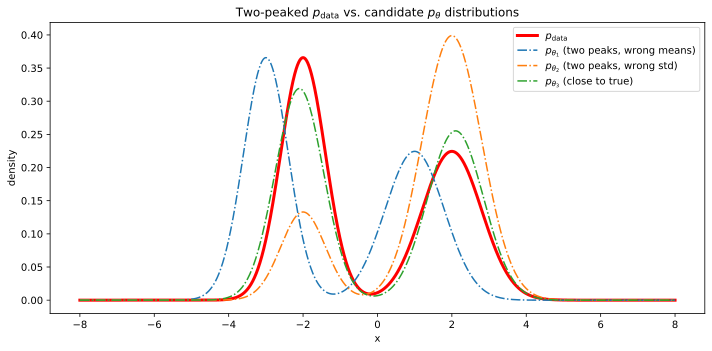

In [136]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Math

# ----------------------------
# 1) Define distributions
# ----------------------------
def normal_pdf(x, mu, sigma):
    return (1.0 / (sigma * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)

def mix_pdf(x, mus, sigmas, weights):
    weights = np.asarray(weights, dtype=float)
    weights = weights / weights.sum()
    p = np.zeros_like(x, dtype=float)
    for w, mu, sig in zip(weights, mus, sigmas):
        p += w * normal_pdf(x, mu, sig)
    return p

# True data distribution p_data: two-peaked Gaussian mixture
p_data_params = dict(mus=[-2.0, 2.0], sigmas=[0.6, 0.8], weights=[0.55, 0.45])

# Candidate model distributions p_theta (intentionally different)
candidates = {
    r"$p_{\theta_1}$ (two peaks, wrong means)": dict(mus=[-3.0, 1.0], sigmas=[0.6, 0.8], weights=[0.55, 0.45]),
    r"$p_{\theta_2}$ (two peaks, wrong std)": dict(mus=[-2.0, 2.0], sigmas=[0.6, 0.8], weights=[0.20, 0.80]),
    r"$p_{\theta_3}$ (close to true)": dict(mus=[-2.1, 2.1], sigmas=[0.65, 0.75], weights=[0.52, 0.48]),
}

# ----------------------------
# 2) Numerical KL divergence on a grid
# ----------------------------
# KL(p||q) = ∫ p(x) log(p(x)/q(x)) dx
x = np.linspace(-8, 8, 20001)  # fine grid
p = mix_pdf(x, **p_data_params)
p = p / np.trapezoid(p, x)  # normalize numerically

EPS = 1e-300  # avoid log(0)

def kl_divergence(p, q, x):
    p_safe = np.maximum(p, EPS)
    q_safe = np.maximum(q, EPS)
    integrand = p_safe * (np.log(p_safe) - np.log(q_safe))
    return float(np.trapezoid(integrand, x))

results = []
q_dict = {}

for ind, (name, params) in enumerate(candidates.items(), start=1):
    q = mix_pdf(x, **params)
    q = q / np.trapezoid(q, x)
    q_dict[name] = q

    kl = kl_divergence(p, q, x)
    results.append((name, kl))

    display(Math(rf"\mathrm{{KL}}\!\left(p_{{\text{{data}}}} \,\|\, p_{{\theta_{ind}}}\right)"
                 rf" = {kl:.6f}\quad \text{{{name}}}"))

# ----------------------------
# 3) Plot PDFs and show KL table
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(x, p, label=r"$p_{\mathrm{data}}$", color="r", linewidth=3)

for name in candidates.keys():
    plt.plot(x, q_dict[name], label=name, linestyle="-.")

plt.xlabel("x")
plt.ylabel("density")
plt.title(r"Two-peaked $p_{\mathrm{data}}$ vs. candidate $p_{\theta}$ distributions")
plt.legend()
plt.tight_layout()
plt.show()

<div style="
  background: #f2f2f2;
  border: 1px solid #d9d9d9;
  border-left: 6px solid #9e9e9e;
  padding: 16px 18px;
  border-radius: 12px;
  font-size: 18px;
  line-height: 1.38;
  margin: 10px 0;
">

  <div style="font-weight: 800; font-size: 20px; margin-bottom: 10px;">
    Theorem (Monte Carlo / sample-average MLE is effective)
  </div>

  <div style="margin-bottom: 10px;">
    Let \(\mathbf{w}^{(1)},\ldots,\mathbf{w}^{(N)} \overset{\text{i.i.d.}}{\sim} p_{\text{data}}\).
    Define the population objective and its Monte Carlo (empirical) estimator:
    \[
      \mu(\theta):=\mathbb{E}_{\mathbf{w}\sim p_{\text{data}}}\!\big[\log p_\theta(\mathbf{w})\big],\qquad
      \hat{\mu}_N(\theta):=\frac{1}{N}\sum_{i=1}^{N}\log p_\theta\!\big(\mathbf{w}^{(i)}\big).
    \]
  </div>

  <div style="margin-bottom: 10px;">
    Assume for each fixed \(\theta\), \(\mathbb{E}_{p_{\text{data}}}[\,|\log p_\theta(\mathbf{w})|\,] < \infty\).
    Then for every fixed \(\theta\),
    \[
      \hat{\mu}_N(\theta)\xrightarrow[N\to\infty]{a.s.}\mu(\theta).
    \]
    Moreover, if the convergence is <em>uniform</em> over \(\theta\in\Theta\),
    \[
      \sup_{\theta\in\Theta}\big|\hat{\mu}_N(\theta)-\mu(\theta)\big|\xrightarrow[N\to\infty]{a.s.}0,
    \]
    and if \(\mu(\theta)\) has a unique maximizer \(\theta^\star=\arg\max_{\theta\in\Theta}\mu(\theta)\),
    then any maximizer of the empirical objective
    \[
      \hat{\theta}_N\in\arg\max_{\theta\in\Theta}\hat{\mu}_N(\theta)
    \]
    is <strong>consistent</strong>: $\hat{\theta}_N \xrightarrow[N\to\infty]{} \theta^\star$
  </div>

  <div style="margin-top: 10px; opacity: 0.95;">
    <strong>Interpretation:</strong> maximizing the empirical average log-likelihood (MC estimate)
    is a principled and effective way to approximate the ideal objective.
  </div>

  <details style="margin-top: 12px;">
    <summary style="cursor: pointer; font-weight: 700;">Proof (click to expand)</summary>
    <div style="margin-top: 10px;">
      <div style="font-weight: 800; margin-bottom: 6px;">Step 1: Fixed-\(\theta\) convergence (Law of Large Numbers).</div>
      For a fixed \(\theta\), define \(X_i(\theta):=\log p_\theta(\mathbf{w}^{(i)})\).
      Since \(\mathbf{w}^{(i)}\) are i.i.d., the random variables \(X_i(\theta)\) are also i.i.d. with
      \(\mathbb{E}[|X_i(\theta)|]<\infty\) by assumption. The Strong Law of Large Numbers implies
      \[
        \frac{1}{N}\sum_{i=1}^{N}X_i(\theta)\xrightarrow[]{a.s.}\mathbb{E}[X_1(\theta)].
      \]
      Substituting back \(X_i(\theta)=\log p_\theta(\mathbf{w}^{(i)})\) gives
      \[
        \hat{\mu}_N(\theta)\xrightarrow[]{a.s.}\mu(\theta).
      \]
      <div style="font-weight: 800; margin: 12px 0 6px;">Step 2: Why uniform convergence matters for the argmax.</div>
      In MLE, \(\theta\) is not fixed: we choose \(\hat{\theta}_N\) by maximizing \(\hat{\mu}_N(\theta)\).
      Pointwise convergence \(\hat{\mu}_N(\theta)\to\mu(\theta)\) for each fixed \(\theta\) does not by itself
      guarantee that the maximizers converge. A standard sufficient condition is a <em>uniform law of large numbers</em>:
      \[
        \sup_{\theta\in\Theta}\big|\hat{\mu}_N(\theta)-\mu(\theta)\big|\xrightarrow[]{a.s.}0.
      \]
      Intuitively, this says the entire empirical objective surface approaches the population surface everywhere.
      <div style="font-weight: 800; margin: 12px 0 6px;">Step 3: Argmax consistency under uniform convergence + uniqueness.</div>
      Assume \(\mu(\theta)\) has a unique maximizer \(\theta^\star\). Fix any \(\varepsilon>0\).
      By uniqueness, there exists a gap \(\gamma(\varepsilon)>0\) such that
      \[
        \mu(\theta^\star) \ge \sup_{\|\theta-\theta^\star\|\ge \varepsilon}\mu(\theta) + 2\gamma(\varepsilon).
      \]
      By uniform convergence, for all large enough \(N\) (almost surely),
      \[
        \sup_{\theta\in\Theta}|\hat{\mu}_N(\theta)-\mu(\theta)| < \gamma(\varepsilon).
      \]
      Then for any \(\theta\) with \(\|\theta-\theta^\star\|\ge \varepsilon\),
      \[
        \hat{\mu}_N(\theta)
        \le \mu(\theta) + \gamma(\varepsilon)
        \le \big(\mu(\theta^\star)-2\gamma(\varepsilon)\big) + \gamma(\varepsilon)
        = \mu(\theta^\star)-\gamma(\varepsilon)
        \le \hat{\mu}_N(\theta^\star).
      \]
      So no parameter outside the \(\varepsilon\)-ball can maximize \(\hat{\mu}_N\); hence any maximizer
      \(\hat{\theta}_N\) must satisfy \(\|\hat{\theta}_N-\theta^\star\|<\varepsilon\) for all large \(N\) (a.s.).
      Because \(\varepsilon\) is arbitrary, \(\hat{\theta}_N\to\theta^\star\).
      <div style="margin-top: 10px;">
        This shows that <strong>maximizing the MC (empirical) log-likelihood reliably recovers the population optimum</strong>
        when \(N\) is large and the model class is well-behaved (so the uniform convergence assumption holds).
        \(\square\)
      </div>
    </div>
  </details>

</div>

<a id="12"></a>
### 1.2 Log probability of sentences

- **Get log probability of sentences**

In [137]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

def get_sentence_probability(sentence, model_id):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")
    inputs = tokenizer(sentence, return_tensors="pt").to(model.device)
    input_ids = inputs["input_ids"]
    
    with torch.no_grad():
        # Passing labels=input_ids tells the model to calculate the cross-entropy loss
        outputs = model(input_ids, labels=input_ids)
        avg_loss = outputs.loss.item()
    
    # Total Log-Likelihood is -(average_loss * sequence_length)
    total_log_prob = -avg_loss * input_ids.shape[1]
    
    return total_log_prob

In [138]:
for model_id in ["Qwen/Qwen3-0.6B", "Qwen/Qwen3-1.7B"]:
    s1 = "He to reporters introduced main content"
    s2 = "He briefed reporters on the main contents of the statement"
    print(f"Sentence 1: [{s1}], Log-Prob: {get_sentence_probability(s1, model_id):.4f}")
    print(f"Sentence 2: [{s2}], Log-Prob: {get_sentence_probability(s2, model_id):.4f}")
    if loss2 < loss1:
        print(f"Sentence 2 is more \"natural\" according to {model_id}.")
    else:
        print(f"Sentence 1 is more \"natural\" according to {model_id}")

Sentence 1: [He to reporters introduced main content], Log-Prob: -56.2687
Sentence 2: [He briefed reporters on the main contents of the statement], Log-Prob: -52.7838
Sentence 2 is more "natural" according to Qwen/Qwen3-0.6B.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk.


Sentence 1: [He to reporters introduced main content], Log-Prob: -65.9077


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk.


Sentence 2: [He briefed reporters on the main contents of the statement], Log-Prob: -45.0296
Sentence 2 is more "natural" according to Qwen/Qwen3-1.7B.


In [139]:
s1 = "It's hard to recognize speech"
s2 = "It's hard to wreck a nice beach"
for model_id in ["Qwen/Qwen3-0.6B"]:
    print(f"Sentence 1: [{s1}], Log-Prob: {get_sentence_probability(s1, model_id):.4f}")
    print(f"Sentence 2: [{s2}], Log-Prob: {get_sentence_probability(s2, model_id):.4f}")
    if loss2 < loss1:
        print(f"Sentence 2 is more \"natural\" according to {model_id}.")
    else:
        print(f"Sentence 1 is more \"natural\" according to {model_id}")

Sentence 1: [It's hard to recognize speech], Log-Prob: -46.3041
Sentence 2: [It's hard to wreck a nice beach], Log-Prob: -55.6418
Sentence 2 is more "natural" according to Qwen/Qwen3-0.6B.


This note introduces the $N$-gram language model. We define the $N$-gram language model and show how to use maximum likelihood estimation to learn these parameters. We then discuss techniques to handle zero probability issues (smoothing) and define perplexity.

**Notations:** A sentence after tokenization is $[w_1, w_2, \ldots, w_t]$ denoted it as $s = w_{1:t}$. For example, for the sentence *"the cat saw the dog"*, we have $s=w_{1:5} = [\textit{the, cat, saw, the, dog}]$. Let $P(X)$ represent the probability distribution of a discrete random variable $X$. We use $w_i$ to denote the random variable $X_i$ at the $i$-th position of $s$. That is, $P(X_i = w_i) \equiv P(w_i)$. Let $X_{i+1}$ represent the choice $w_{i+1}$, and $X_i$ represent $w_i$, which occurs before $w_{i+1}$. Then, $P(X_i, X_{i+1})$ is the probability of $w_i w_{i+1}$, which we write as $P(X_i = w_i, X_{i+1} = w_{i+1}) \equiv P(w_{i:i+1})$. We define the vocabulary $\mathcal{V} = \{v_1,v_2,\ldots,v_{|\mathcal{V}|}\}$ and two special symbols $v_0=\text{BOS}$ and $v_{|\mathcal{V}|+1} = \text{EOS}$ presenting the beginning and end of a sentence, respectively.

**Summary of our motivation:** Say you have a speech recognition task where you need to design a speech recognizer. Given an acoustic signal, the recognizer produces two possible sentences: $s_1 =$*"It's hard to recognize speech"* and $s_2 =$*"It's hard to wreck a nice beach"*. If the model is good enough, it will produce probabilities such that $P(s_1) > P(s_2)$ because both $s_1$ and $s_2$ have very similar acoustic signals, but $s_1$ is more realistic in everyday language. Thus, the speech recognizer needs to be able to assign probabilities to different sentence sequences, comparing how likely $s_1$ and $s_2$ are to occur in the real world. The task of language modeling is to assign probabilities to sentences. In other words, we want to learn a model—specifically, the distribution $P$—that satisfies $P\left(s_1\right) > P\left(s_2\right)$.

**Our task:** The goal is to learn a language model given a *training* corpus, which consists of a set of sentences in some language $\mathcal{V}$. Using this training corpus, we aim to learn a language model. Then, we use a *validation* corpus to tune the hyperparameters of the model. Finally, the *test* corpus is used to evaluate the performance of the trained language model.

<a id="2"></a>
## 2. Understanding N-gram LMs

<a id="21"></a>
### 2.1 Statistical LMs and $N$-gram

A statistical language model defines a probability distribution over sentences from a given language vocabulary $\mathcal{V}$. A possible vocabulary of English language model could be $\mathcal{V}=\{\textit{the}, \textit{dog}, \textit{laughs}, \textit{saw},\ldots\}$ where we assume $\mathcal{V}$ is a finite set. A *sentence* in the language is a sequence of words

$$s=w_1 w_2 \ldots w_t \equiv w_{1:t},$$

where the integer $t\geq 1$ is not fixed and $w_i \in \mathcal{V}$ for $i \in\{1,\ldots,t-1\}$, and we assume that $w_t = \text{EOS}$ is a special symbol, which is not in $\mathcal{V}$. We define $\mathcal{V}^{\dagger}$ to be the set of all sentences with the vocabulary $\mathcal{V}$. The set $\mathcal{V}^{\dagger}$ is an infinite set because sentences can be of any length. For example, $\mathcal{V}^{\dagger}$ could be like,

$$\mathcal{V}^{\dagger} = \{\text{the dog barks EOS}, \text{the EOS}, \text{cat cat cat EOS}, \text{EOS}, \ldots\}.$$

A language model computes the probability of $w_{1:t}$, $p(w_{1:t})$, which can be formally defined as

> **Definition (Language model (LM))**  
> Given a finite vocabulary set $\mathcal{V}$, for any $t\geq 1$, a $t$-length sentence is a sequence $w_{1:t}$ where each $w_i \in \mathcal{V} \equiv \{v_1, \ldots, v_{|\mathcal{V}|}\}$ for $i=1,2,\ldots,t-1$ and $w_t = \text{EOS}$. Let $\mathcal{V}^{\dagger}$ be the set of such sentences. A language model is a probability distribution function $p(w_{1:t})$ over $\mathcal{V}^{\dagger}$ such that
> 
> - For any $w_{1:t} \in \mathcal{V}^{\dagger}, p(w_{1:t}) \geq 0$.
> - In addition, $\sum_{w_{1:t} \in \mathcal{V}^{\dagger}} p(w_{1:t})=1$.

Hence, $p\left(w_{1:t}\right)$ defined above is a probability distribution over $\mathcal{V}^{\dagger}$. This language model enables us to *understand*: Given a sentence $w_{1:t}$, we can use $p$ to compute $p(w_{1:t})$ so that we can compare the probabilities of any two sentences; and to *generate*: the distribution $p$ can be employed to generate sentences. One can use the Chain rule to decompose it as a product of conditional probability as

$$p\left(w_{1:t}\right) = \prod_{i=1}^t p\left(w_i|w_{1:i-1}\right),$$

where $p\left(w_1|w_{1:0}=\text{EOS}\right) = p\left(w_1\right)$ by default and $w_{1:i-1}$ is called *history* of $w_i$. Computing $p(w_{1:t})$ *exactly* is generally difficult or impossible. For example, if one only wants to compute sentences with five words $p(w_{1:5})$ and the vocabulary size $|\mathcal{V}|= 10^4$. Then, we need to know all possible $p(w_{1:5})$, which is about $10^{4\times 5}=10^{20}$ parameters only for $p(w_{1:5})$. So far, all language models we have seen are certain models that try to *estimate* $p\left(w_{1:t}\right)$ from some training text. Of course, we hope that the training text can well sample the language. There are roughly three types of language models:

1. **Statistical language models**: These models use statistical methods to predict the next word in a sentence based on the probabilities of word sequences, known as $N$-gram models.
2. **Neural language models**: These are based on neural networks and include various architectures like two-layer neural networks (word2vec) and RNNs (e.g., LSTMs, GRUs).
3. **Large language models (LLMs)**: Neural network model that uses self-attention mechanisms (Transformers), such as the BERT and GPT (Generative Pre-trained Transformer) families.

Why we need $w_t = \text{EOS}$? In our definition of the sentence $w_{1:t}$, the sentence length $t$ is itself a random variable. There are various ways of modeling this variability in length. However, the most common language modeling approach is assuming that the last word, $w_t$, is always equal to a special symbol, EOS. This symbol can only appear at the end of a sequence.  Approximating $p(w_{1:t})$ is key to building a practical language model. For example, under a first-order Markov assumption, we can approximate it as $p(w_{1:t}) = P(X_{1:t}=w_{1:t})=\prod_{i=1}^t P(X_i=w_i \mid X_{i-1}=w_{i-1})$. Similarly, under the second-order Markov assumption, we can approximate it as

$$p(w_{1:t}) = P(X_{1:t}=w_{1:t})=\prod_{i=1}^t P(X_i=w_i \mid X_{i-2}=w_{i-2}, X_{i-1}=w_{i-1}),$$

for any $t \geq 1$. The second-order Markov process generates a symbol $x_i$ from the distribution

$$P\left(X_i=x_i \mid X_{i-2}=x_{i-2}, X_{i-1}=x_{i-1}\right),$$

where $x_i \in \mathcal{V} \cup \{\text{EOS}\}$. To sample a sentence from $P$, we can do the following: If we generate the EOS symbol, we finish the sequence. Otherwise, we continue to generate the next symbol in the sequence. A little more formally, the process that generates sentences would be as follows:

- **Step 1:** Initialize $i=1$, and $x_0=x_{-1}=\text{BOS}$
- **Step 2:** Generate $x_i$ from the distribution $p\left(X_i= x_i \mid X_{i-2:i-1}=x_{i-2:i-1}\right)$
- **Step 3:** If $x_i=$ EOS, then return $x_{1:i}$. Otherwise, set $i=i+1$ and return to **Step 2**.

Thus, the model generates sentences that vary in length. The $N$-gram model can be defined as

> **Definition ($N$-gram LM)**  
> Given the finite vocabulary set $\mathcal{V}$, for any $t\geq 1$, a $t$-length sentence is a sequence $w_{1:t}$ where each $w_i \in \mathcal{V} \equiv \{v_1, \ldots, v_{|\mathcal{V}|}\}$ for $i=1,2,\ldots,t-1$ and $w_t = \text{EOS}$. For any sentence $w_{1:t}$, the $N$-gram language model computes the probability of sentence $w_{1:t}$, $p(w_{1:t})$, by using the $(N-1)$-order of Markov assumption, that is
> 
> $$p\left(w_{1:t}\right) = \prod_{i=1}^t q\left(w_i \mid w_{i-N+1:i-1}\right),$$
> 
> where the function $q(x_{N}|x_{1:N-1})$ is the conditional probability distribution of $N$-gram $x_{1:N}$ where $x_i \in \mathcal{V} \cup\{\text{BOS}\}$ for $i=1,2,\ldots,N-1$ and $x_N \in \mathcal{V} \cup \{\text{EOS}\}$. The value for $q(x_N \mid x_{1:N-1})$ can be interpreted as the probability of seeing the word $x_N$ immediately after the gram $x_{1:N-1}$. By default, we define $w_i=\text{BOS}$ for any $i\leq 0$.

For example,

- When $N=1$, the $p$ is an *unigram* LM where $p\left(w_{1:t}\right) = \prod_{i=1}^t q\left(w_i\right)$.
- When $N=2$, we call $p$ a *bigram* LM where $p\left(w_{1:t}\right) = \prod_{i=1}^t q\left(w_i | w_{i-1}\right)$.
- When $N=3$, we call it a *trigram* LM where $p\left(w_{1:t}\right) = \prod_{i=1}^t q\left(w_i \mid w_{i-2:i-1}\right)$.

In the above definition, $q(x_N|x_{1:N-1})$ are parameters that will be learned from the training corpus. For example, the parameters satisfy the constraints that for any trigram $(u, v, w)$, $q(w \mid u, v) \geq 0$ and for any bigram $u, v$, $\sum_{w \in \mathcal{V} \cup\{\text{EOS}\}} q(w \mid u, v)=1$. Thus $q(w \mid u, v)$ defines a distribution over possible words $w$, conditioned on the bigram context $u, v$. The key problem we are left with is estimating the model parameters $q(x_N \mid x_{1:N-1})$. The model has around $|\mathcal{V}|^{N}$ parameters. This is likely to be a very large number. For example, with $|\mathcal{V}|=10,000$, we have $|\mathcal{V}|^3 \approx 10^{12}$ number of parameters.

<a id="22"></a>
### 2.2 Learning parameters via MLE

<div style="
  background: rgba(0,0,0,0.05);
  border: 0px solid rgba(0,0,0,0.1);
  border-radius: 6px;
  padding: 15px 15px;
  line-height: 1.2;
">

To estimate $q(x_N|x_{1:N-1})$, a reasonable process is to collect a set of raw text (e.g., Wikipedia pages, Web context, books, etc) as training dataset $\mathcal{D}_{\text{tr}}$. After the tokenization, it is

$$\mathcal{D}_{\text{tr}}= \left\{ s_1, s_2,\ldots, s_T\right\} \equiv s_{1:T}, \text{ where } s_i = w_{1:t_i}^{(i)} \in \mathcal{V}^{\dagger},$$

where $T$ is the total number of sentences in $\mathcal{D}_{\text{tr}}$. We can estimate $q(\cdot)$ based on $\mathcal{D}_{\text{tr}} = s_{1:T}$. Let us assume $d$ unknown parameters parameterize $P$. We write the parameters governing the joint distribution as a vector $\mathbf{\theta}=\left[\theta_1, \theta_2, \ldots, \theta_d\right]^{\top}$ so that $P$ falls within a parametric family $\{P(\mathcal{D}; \mathbf{\theta}) \mid \mathbf{\theta} \in \Theta \subseteq \mathbb{R}^d\}$ where $\Theta$ is the parameter space. Maximum likelihood estimation (MLE) estimates the parameters of an assumed probability distribution given some observed data $\mathcal{D}$. **Maximum likelihood estimation (MLE) aims to determine the parameters $\mathbf{\theta}$ for which the observed data have the highest joint probability.**  Specifically, to maximize the likelihood function of $T$ random sentences in $\mathcal{D}_{\text{tr}}$, one needs to solve the following optimization problem

$$\hat{\mathbf{\theta}} \in \arg \max_{ \mathbf{\theta} \in \mathbf{\Theta} } \left\{  \mathcal{L}_T(\mathbf{\theta} ; \mathcal{D}_{\text{tr}}) := P(s_{1:T}; \mathbf{\theta})  \right\}.$$

The above MLE allows us to estimate the $N$-gram model. There are two questions: What are the parameters $\mathbf{\theta}$ of unigram, bigram, and trigram? and How to estimate these parameters $\mathbf{\theta}$?

</div>

<a id="23"></a>
### 2.3 MLE for unigram model

<div style="
  background: rgba(0,0,0,0.05);
  border: 0px solid rgba(0,0,0,0.1);
  border-radius: 6px;
  padding: 15px 15px;
  line-height: 1.2;
">
Given the training corpus $\mathcal{D}_{\text{tr}} = \{s_1,s_2,\ldots,s_T\}$ observed from true distribution $P$. Under the assumption of the unigram model, we have

$$P(s_{1:T}) = \prod_{i=1}^{T} P(s_i \equiv w_{1:t_i}^{(i)} ) = \prod_{i=1}^{T} \prod_{j=1}^{t_i} q(w_{j}^{(i)}) = \prod_{i=1}^{|\mathcal{V}|+1} q(v_i)^{C(v_i)} = \prod_{i=1}^{|\mathcal{V}|+1} \theta_{i}^{C(v_i)},$$

where we assume sentences $s_i$ are independent with each other, the count $C(v_i) = \sum_{i=1}^T |\{w_j^{(i)} : w_j^{(i)} = v_i, j = 1,\ldots,t_i\}|$ denotes the number of $v_i$ in $s_{1:T}$, the parameter vector $\mathbf{\theta} = [\theta_1,\theta_2,\ldots,\theta_{|\mathcal{V}|},\theta_{\text{EOS}}]^\top$ with $\theta_i := q(v_i)$. Indeed, the parameter $\mathbf{\theta}$ completely defines the distribution $P(w_{1:t})$, and we have the constraint that $\sum_{i=1}^{|\mathcal{V}|+1} \theta_i = \sum_{i=1}^{|\mathcal{V}|+1} q\left(v_i\right) = 1$. We continue to write out the likelihood function

$$\mathcal{L}_T(\mathbf{\theta} ; \mathcal{D}_{\text{tr}}) := P(s_{1:T}; \mathbf{\theta}) = \prod_{i=1}^T P(s_i; \mathbf{\theta}) = \prod_{i=1}^{|\mathcal{V}|+1} q\left(v_i; \mathbf{\theta}\right)^{C\left(v_i\right)} = \prod_{i=1}^{|\mathcal{V}|+1} \theta_i^{C\left(v_i\right)}.$$

To solve the MLE problem, it is equivalent to maximize the log of $\mathcal{L}$, we have

$${\mathbf{\theta}}^* \in \arg \max_{ \mathbf{\theta} \in \{ \mathbf{x}: \|\mathbf{x}\|_1 =1\}} \big\{  \mathcal{L}_T(\mathbf{\theta} ; \mathcal{D}_{\text{tr}}) := P(s_{1:T}; \mathbf{\theta})  \big\} = \arg \max_{ \sum_{j} \theta_j = 1 } \sum_{i=1}^{|\mathcal{V}|+1} C\left(v_i\right) \log \theta_i.$$

Since the constraint set is convex, it is a convex-constrained optimization problem as the following

$$\max_{\mathbf{\theta}} \sum_{i=1}^{|\mathcal{V}|+1} C(v_i) \log \theta_i, \text{ subject to }  \sum_{i=1}^{|\mathcal{V}|+1} \theta_{i} = 1.$$

To solve this convex-constrained optimization problem, we introduce a scalar $\lambda$ called a *Lagrange multiplier* (one for each constraint), rewrite the equality constraint as $E(x)=0$, and define a new Lagrangian function of the form $G(x, \lambda)=F(x)-\lambda E(x)$, where $F(x)$ is the original objective. Then, we just need to check the saddle points of the Lagrangian function $G$. In our case, the Lagrangian is

$$G(\mathbf{\theta}, \lambda) := \sum_{i=1}^{|\mathcal{V}|+1} C(v_i) \log \theta_{i} - \lambda\left(\sum_{i=1}^{|\mathcal{V}|+1} \theta_i - 1\right) = \sum_{i=1}^{|\mathcal{V}|+1}( C(v_i) \log \theta_i - \lambda \theta_i) + \lambda = \sum_{i=1}^{|\mathcal{V}|+1} g( \theta_i) + \lambda,$$

where $g(\theta_i) := C(v_i) \log \theta_i - \lambda \theta_i$ is a concave function and $G$ is linear in term of $\lambda$. Hence, $G(\mathbf{\theta},\lambda)$ is decomposible concave function in terms of $\mathbf{\theta}$, one can get maximal value of $\mathcal{L}$ by getting the saddle points of $G$. The function $g_i$ is differentiable and concave, and we set the gradient of $g_i$ to zero to get such saddle point (Since the original objective is concave and constraint equation is linear, then the saddle point is unique. To find this saddle point, we just need to letting gradient of $\mathbf{\theta}$ and $\lambda$ be zeros.)

$$\begin{aligned}
\frac{\partial g_i }{\partial \theta_i} & =\frac{C (v_i) }{\theta_i} -\lambda=0, \text{ for } i = 1,2,\ldots, |\mathcal{V}|+1. \\
\frac{\partial G }{\partial \lambda} & =\sum_{i=1}^{|\mathcal{V}|} \theta_i -1=0
\end{aligned}$$

which gives $\lambda = \sum_{i=1}^T |s_i| = \sum_{i=1}^{|\mathcal{V}|+1} C(v_i)$ and each optimal $\theta_i^*$ is

$${\theta}_i^* = \frac{C(v_i)}{\sum_{i=1}^{|\mathcal{V}|+1} C(v_i) }=\frac{C(v_i)}{\sum_{i=1}^T |s_i|},$$

where $\sum_{i=1}^T |s_i|$ is the number of tokens in training corpus $s_{1:T}$. It can be seen that the purpose of $\lambda = \sum_{i=1}^{|\mathcal{V}|+1} C(v_i)$ is normalization. Therefore, the parameter estimation of MLE for the unigram model is simply the frequency estimate for the unigram model!
</div>

<a id="24"></a>
### 2.4 MLE for bigram model

<div style="
  background: rgba(0,0,0,0.05);
  border: 0px solid rgba(0,0,0,0.1);
  border-radius: 6px;
  padding: 15px 15px;
  line-height: 1.2;
">

For bigram model, given a training dataset $\mathcal{D}_{\text{tr}} = s_{1:T}$ where each sentence $s_i = w_{1:t_i}^{(i)}$, we have

$$P(s_{1:T}) = \prod_{i=1}^T P(s_i) = \prod_{i=1}^T \prod_{j=1}^{t_i} q(w_{j}^{(i)}|w_{j-1}^{(i)}) = \prod_{i=0}^{|V|} \prod_{j=0}^{|V|} q(v_{j+1} | v_i)^{C(v_i, v_{j+1})},$$

where $C(v_i,v_{j+1})$ is the number of bigram $(v_i,v_{j+1})$ appeared in $s_{1:T}$. We may need to consider the conditional probability $q(v_{j+1}|v_i)$ more carefully. Recall we defined $v_0= \text{EOS}$ as the starting mark of a sentence. Let $\theta_{i,j+1} := q(v_{j+1}|v_i)$, and $\mathbf{\theta}_i = [\theta_{i,1},\theta_{i,2},\ldots,\theta_{i,|\mathcal{V}|+1}]^\top$ for $i=0,1,\ldots,|V|$. Indeed, these $\mathbf{\theta}_i$ completely define the distribution $p(w_{1:t})$, and we have the constraint that $\sum_{j=0}^{|\mathcal{V}|} \theta_{i,j+1} = \sum_{j=0}^{|\mathcal{V}|} q\left(v_{j+1}|v_i\right) = 1$ for all $i=0,1,\ldots,|V|$. We continue to write out the log-likelihood function

$$\log P(s_{1:T};{\mathbf{\Theta}}) = \sum_{i=0}^{|\mathcal{V}|} \sum_{j=0}^{|\mathcal{V}|} C\left(v_i, v_{j+1}\right) \log q\left(v_{j+1} \mid v_i\right).$$

To maximize the above score, equivalently, we have the following optimization problem:

$$\max_{\mathbf{\theta}_{0:|\mathcal{V}|}} \log P(s_{1:T};\mathbf{\theta}_{0:|\mathcal{V}|}), \text{ subject to } \sum_{j=0}^{|\mathcal{V}|} \theta_{i,j+1} = 1, \forall \ i =0,1,\ldots,|\mathcal{V}|.$$

Similar to the unigram model, we introduce $|\mathcal{V}|+1$ Lagrange multipliers $\lambda_i$ for each equation constraint  $\sum_{j=0}^{|\mathcal{V}|}  \theta_{i,j+1} -1=0$ for $i=0,1,\ldots,|\mathcal{V}|$. We have the following Lagrangian function

$$\mathcal{G}(\mathbf{\theta}_{0},\ldots, \mathbf{\theta}_{|\mathcal{V}|},\mathbf{\lambda}) := \sum_{i=0}^{|\mathcal{V}|} \sum_{j=0}^{|\mathcal{V}|} C\left(v_i, v_{j+1}\right) \log \theta_{i,j+1} - \sum_{i=0}^{|\mathcal{V}|} \lambda_i\left( \sum_{j=0}^{|\mathcal{V}|} \theta_{i,j+1} -1\right),$$

where again, we can decompose $\mathcal{G}$ function into $n$ concave function, and the corresponding optimal solution $\mathbf{\theta}_0^*,\ldots, {\mathbf{\theta}}_{|\mathcal{V}|}^*$ are obtained by letting the gradient of $\theta_{i,j+1}$ be 0:

$$\frac{\partial \mathcal{L}}{\partial \theta_{i,j+1}} = \frac{C(v_i, v_{j+1})}{ \theta_{i,j+1}} - \lambda_i=0 \quad\Rightarrow\quad
\theta_{i,j+1}^* = \frac{C(v_i, v_{j+1})}{\lambda_i}.$$

To compute $\lambda_i$, note that $\sum_{j=0}^{|\mathcal{V}|} \theta_{i,j+1} =1$, we have

$$\sum_{j=0}^{|\mathcal{V}|} \theta_{i,j+1} = \sum_{j=0}^{|\mathcal{V}|}  \frac{C(v_i, v_{j+1})}{\lambda_i} = \frac{\sum_{j=0}^{|\mathcal{V}|} C(v_i, v_{j+1})}{\lambda_i}=1 \quad \Rightarrow \quad \lambda_i = \sum_{j=0}^{|\mathcal{V}|} C(v_i, v_{j+1}).$$

Hence, we plug $\lambda_i$ into the solution, we obtain

$$\theta_{i,j+1}^* = q(v_{j+1} \mid v_i) = \frac{C(v_i, v_{j+1})}{\sum_{j=0}^{|\mathcal{V}|} C(v_i, v_{j+1})}.$$

For the trigram model and beyond, the MLE of the estimate $q\left(x_N \mid x_{1:N-1}\right)$ is given by

$$q\left(x_N \mid x_{1: N-1}\right) = \frac{C(x_{1:N})}{C(x_{1: N-1})}.$$

</div>

<a id="25"></a>
### 2.5 Smoothing for $N$-gram LMs

<div style="
  background: rgba(0,0,0,0.05);
  border: 0px solid rgba(0,0,0,0.1);
  border-radius: 6px;
  padding: 15px 15px;
  line-height: 1.2;
">

$N$-gram models usually have sparsity issues. For example, after observing all trigrams (i.e., consecutive word triplets) in 38 million words' worth of newspaper articles, a third of trigrams in new articles from the same source are novel. Furthermore, even among the observed trigrams, the vast majority occurred only once, and the majority of the rest had similarly low counts.

Therefore, straightforward MLE of $N$-gram probabilities from counts is not advisable. Instead, various smoothing techniques have been developed. These include discounting MLE, recursively backing off to lower order $N$-grams, and linearly interpolating $N$-grams of different order.

To keep a language model from assigning zero probability to these unseen events, we will have to shave off a bit of probability mass from some more frequent events and give it to the events we have never seen. The following gives you some smoothing techniques to avoid probability zero.

- **Additive smoothing.** To avoid zero probabilities, we pretend that each $N$-gram occurs slightly more often than it does: we add a factor $\delta$ to every count, where typically $0<\delta \leq 1$. Thus, we set

$$q_{\text{Add}}(x_N \mid x_{1:N-1}) = \frac{\delta+C(x_{1:N})}{\delta(|\mathcal{V}|+1)+\sum_{x_N\in \mathcal{V} \cup \text{EOS} } C(x_{1:N})}.$$

The simplest smoothing method above is adding one smoothing ($\delta = 1$) to all the $N$-gram counts. Since there are $|\mathcal{V}|$ words in the vocabulary, and each one was incremented, we also need to adjust the denominator to account for the extra $|\mathcal{V}|$ observations.

- **Linear interpolation.** By contrast, in the linear interpolation, we always mix the probability estimates from all the $N$-gram estimators, weighting and combining the trigram, bigram, and unigram counts. For example, consider the trigram model; the linear interpolation gives

$$q_{\text{Int}}(x_3 \mid x_{1:2})= \lambda_1 \cdot q_{\text{ML}}(x_3) + \lambda_2 \cdot q_{\text{ML}}(x_3 \mid x_{2}) + \lambda_3 \cdot q_{\text{ML}}\left(x_3 \mid x_{1:2}\right),$$

where $\lambda_1, \lambda_2$, and $\lambda_3$ are parameters such that $\sum_{i=1}^3 \lambda_i=1$ which are learned from validation text. Furthermore, $q_{\text{ML}}(x_3 \mid x_1, x_2) = \frac{C(x_{1:3})}{C(x_{1:2})} , q_\text{ML}(x_3 \mid x_2) =\frac{C(x_{2:3})}{C(x_2)}, q_{\text{ML}}(x_3) = \frac{C(x_3)}{ \sum_{i=1}^T t_i}$. One extension to the method, often referred to as *bucketing*, is a much simpler method defined as

$$\begin{aligned}
& \lambda_1=\frac{C(x_{1:2})}{C(x_{1:2})+\gamma}, \quad \lambda_2=\left(1-\lambda_1\right) \times \frac{C(x_2)}{C(x_2)+\gamma}, \quad \lambda_3=1-\lambda_1-\lambda_2,
\end{aligned}$$

where $\gamma>0$ is the only parameter. One can verify that $\lambda_i$ are positive and $\lambda_1 + \lambda_2 + \lambda_3=1$.

- **Katz Back-off (discounting).** The back-off smoothing strategy is recursively defined. We first consider the bigram model where, for any $x_1$, define the sets

$$\mathcal{A}(x_1)=\{x_2: C(x_1 x_2)>0\}, \quad \text{ and } \quad \mathcal{B}(x_1)=\{x_2: C(x_1 x_2)=0\}.$$

Then, the estimate is defined as

$$q_{\text{Katz}}(x_2 \mid x_1)= \begin{cases}\frac{C^*(x_1, x_2)}{C(x_1)} & \text { If } x_2 \in \mathcal{A}(x_1) \\ \alpha(x_1) \cdot \frac{q_{\text{ML}}(x_2)}{\sum_{x_2 \in \mathcal{B}(x_1)} q_{\text{ML}}(x_2)} & \text { If } x_2 \in \mathcal{B}(x_1)\end{cases},$$

where $C^*$ is the discounted count. For any bigram $C(x_1, x_2)$ such that $C(x_1, x_2)>0$, we define the discounted count as

$$C^*(x_1, x_2)=C(x_1, x_2)-\beta,$$

where $\beta\in [0,1]$ (a typical value might be $\beta=0.5$ ). Thus, we simply subtract a constant value, $\beta$, from the count. This reflects the intuition that if we take counts from the training corpus, we will systematically over-estimate the probability of bigrams seen in the corpus (and under-estimate bigrams not seen in the corpus). In other words, if $C(x_1,x_2)>0$, we return the estimate $C^*(x_1,x_2) / C(x_1)$; otherwise, we divide the remaining probability mass $\alpha(x_1)$ in proportion to the unigram estimates $q_{\text{ML}}(x_2)$. The method can be generalized to trigram language models in a natural way: for any bigram $(u, v)$ define

$$\mathcal{A}(u, v)=\{w: c(u, v, w)>0\}, \quad \text{ and } \mathcal{B}(u, v)=\{w: c(u, v, w)=0\}.$$

Define $C^*(u, v, w)$ to be the discounted count for the trigram $(u, v, w)$ : that is, $C^*(u, v, w)=C(u, v, w)-\beta$ where $\beta$ is again the discounted value. Then, the trigram model is

$$q_{\text{Katz}} (w \mid u, v)= \begin{cases}\frac{C^*(u, v, w)}{C(u, v)} & \text { If } w \in \mathcal{A}(u, v) \\ \alpha(u, v) \times \frac{q_{ \text{Katz} }(w \mid v)}{\sum_{w \in \mathcal{B}(u, v)} q_{\text{Katz}}(w \mid v)} & \text { If } w \in \mathcal{B}(u, v)\end{cases},$$

where $\alpha(u, v)=1-\sum_{w \in \mathcal{A}(u, v)} \frac{C^*(u, v, w)}{C(u, v)}$ is again the "missing" probability mass. Note that we have divided the missing probability mass in proportion to the bigram estimates $q_{\text{Katz}}(w \mid v)$, which were defined previously.

- **Kneser-Ney Smoothing.** Given the discount parameter $\delta$ with $0 \leq \delta \leq 1$, the Kneser-Ney smoothing for bigram model is

$$q_{\text{KN}}\left(x_2 \mid x_1 \right)=\frac{\max \left\{C\left(x_1 x_2\right) - \delta, 0\right\}}{ \sum_{x \in \mathcal{V} \cup \text{EOS}} C(x_1 x)} + \lambda_{x_1} \cdot q_{\text{KN}}\left(x_2\right)$$

where the unigram probability $q_{\text{KN}}\left(x_2\right)$ depends on how likely it is to see the word $x_2$ in an unfamiliar context, which is estimated as the number of times it appears after any other word divided by the number of distinct pairs of consecutive words in the corpus:

$$q_{\text{KN}}\left(x_2\right) =\frac{|\{x: C(x x_2)>0\}|}{\left|\left\{(x_1,x_2): C\left(x_1x_2\right)>0\right\}\right|}.$$

The parameter $\lambda_{x_1}$ can be calculated as

$$\lambda_{x_1} = \frac{\delta \cdot \left|\left\{w: C\left(x_1 w\right)>0\right\}\right|}{\sum_v C\left(x_1 v\right)}.$$

Just like Katz smoothing, we can extend KN smoothing to $N$-gram as follows

$$q_{\text{KN}}(x_N \mid x_{1:N-1}) = \frac{\max \left\{C(x_{1:N})-\delta, 0\right\}}{\sum_{x \in \mathcal{V}\cup \text{EOS} } C\left(x_{1:N-1} x\right)}+\lambda_{x_{1:N-1}} q_{\text{KN}}\left(x_N \mid x_{1:N-1}\right),$$

where

$$\lambda_{1:N-1} = \frac{ \delta\cdot \left|\left\{x: C(x_{1:N-1} x) > 0 \right\}\right|}{\sum_{x \in \mathcal{V} \cup \text{EOS} } C\left(x_{1:N-1} x\right)}.$$

A modified Kneser-Ney smoothing is implemented in [kenlm](https://github.com/kpu/kenlm).

- **Stupid Back-off.** Back-off without discounting (not a true probability) is defined as

$$\begin{aligned}
S\left(x_N \mid x_{1:N-1}\right) &= \left\{\begin{array}{c}
\frac{C(x_{1:N})}{C(x_{1:N-1})} \quad\quad\quad\quad\quad \text { if } C(x_{1:N})>0 \\
0.4 \cdot S(x_N \mid x_{2:N-1}) \quad \text { otherwise }
\end{array}\right. \\
S\left(x_N\right) &= \frac{C(x_N)}{T},
\end{aligned}$$

where $T$ is the size of the total training corpus.
</div>

<a id="26"></a>
### 2.6 Evaluating ngram LMs via perplexity

<div style="
  background: rgba(0,0,0,0.05);
  border: 0px solid rgba(0,0,0,0.1);
  border-radius: 6px;
  padding: 15px 15px;
  line-height: 1.2;
">

Assume we have some test data sentences (examples of new, unseen sentences) $s_1, s_2, \ldots s_m$. Each $s_i:= w_{1:t_i}^{(i)}$. Since a good model should "predict" these real-world sentences well, the total probability assigned to these testing sentences should be high. So, the intuition is that the higher the probability assigned, the better the language model is at modeling unseen sentences. For any $s_i$, we can measure its probability $p\left(s_i\right)$ under the language model. A natural measure of the quality of the language model would be the probability it assigns to the entire set of test sentences, that is

$$\prod_{i=1}^m p\left(s_i\right)$$

The perplexity on $s_{1:m}$ is derived as a direct transformation of this quantity. Define $M := \sum_{i=1}^m t_i$ to be the total number of words in the test corpus. Then the average log probability under the model is defined as

$$\frac{1}{\sum_{i=1}^m |s_i|} \log_2 \prod_{i=1}^m p\left(s_i\right)=\frac{1}{\sum_{i=1}^m |s_i|} \sum_{i=1}^m \log_2 p\left(s_i\right).$$

This is just the log probability of the entire test corpus divided by the total number of words in $s_{1:m}$. Again, the higher this quantity is, the better the language model. The perplexity is then defined as

$$\operatorname{PPL}(s_{1:m}) := 2^{-l}, \quad \text{ where } l=\frac{1}{\sum_{i=1}^m |s_i|} \sum_{i=1}^m \log_2 p\left(s_i\right).$$

Thus, we take the negative of the average log probability and raise it to power two. The perplexity is a positive number. The smaller the perplexity value, the better LM is at modeling unseen data. We can understand the quantity of perplexity as: "*If we randomly picked words from the probability distribution calculated by the language model at each time step, on average, how many words would it have to pick to get the correct one?*" (Neubig, 2017, Page 9). For example, if we assume the language model is the uni-gram model and take all words that occurred in the training set with equal probability, then, for the testing sequence $s_{1:m}$, $\operatorname{PPL}(s_{1:m}) = p(s_{1:m})^{-1/M} = (1/|\mathcal{V}|)^{M\cdot (-1/M)} = |\mathcal{V}|$. On average, we have to pick $|\mathcal{V}|$ words to get the correct one. It is true because every word occurs with equal probability. For another example, if $|\mathcal{V}|=1,000,000$ and there is a good language model with perplexity $\operatorname{PPL}(s_{1:m})=30$, we must pick about 30 words to get the "correct" one.
</div>

<details>
    <summary style="cursor:pointer; font-weight:700; font-size: 18px;">
        Click to expand: Entropy and cross-entropy
    </summary>

<div style="
  background: rgba(0,0,0,0.05);
  border: 0px solid rgba(0,0,0,0.1);
  border-radius: 6px;
  padding: 15px 15px;
  line-height: 1.2;
">
    
**Entropy and cross-entropy:** What is the relation between perplexity and entropy? The perplexity essentially measures the entropy of a language model. Another way to understand the perplexity is to see its relationship to cross-entropy. Given a discrete random variable $X$, with possible outcomes $x_1,\ldots, x_n$, which occur with probability $p(x_1), \ldots, p( x_n)$, the *entropy* of $X$ is defined as

$$H(p) \triangleq - \sum_{i=1}^n p( x_i) \cdot\log p(x_i).$$

The *cross-entropy* of the distribution $q$ relative to a distribution $p$ over a given set is defined as $H(p,q)=- \mathbb{E}_{p}[\log q]$ where $\mathbb{E}_{p}[\cdot]$ is the expectation with respect to $p$. We assume two distribution $p$ and $q$ are discrete and take outcomes $x_i$ from $\mathcal{X}$, we have

$$H(p, q) = - \sum_{x_i \in \mathcal{X}} p(x_i) \log q(x_i).$$

In the language model, we want to estimate the true distribution $p$ of words in any corpus, and $q$ is the distribution we estimated from a training corpus. To evaluate $p$, we may want to see its entropy $H(p)$ but we cannot directly calculate $H(p)$ or $H(p,q)$ since we do not know the true distribution $p$. However, we know an estimation of $p$, which is $q$ learned from a training corpus. The key idea of measuring $H(p)$ is that we can find an estimation of $H(p)$ based on $q$. To make this idea more specific, again, we assume two distributions $p$ and $q$ are discrete and take outcomes $x_i$ from the space $\mathcal{X}$, we have

$$\begin{align}
H(p, q) = - \sum_{x_i \in \mathcal{X}} p(x_i) \log q(x_i) &= - \sum_{x_i \in \mathcal{X}} p(x_i) \left( \log p(x_i) + \log q(x_i) - \log p(x_i) \right) \\
&= H(p) + \underbrace{\sum_{x_i \in \mathcal{X}} p(x_i) \left(\log p(x_i) - \log q(x_i)\right)}_{D_{\operatorname{KL}(p\| q)} \geq 0} \geq H(p),
\end{align}$$

where the last inequality from the fact that the Kullback-Leibler (KL) divergence of $p$ and $q$ (also called relative entropy) measures the relative information gain if $p$ would be used instead of $q$ which is currently used. Notice that the KL divergence is always non-negative, i.e. $D_{\operatorname{KL}}(p || q) \geq 0$. One can use the Gibbs' inequality, i.e., $\sum _{i=1}^{n}p_{i}\log p_{i} \geq \sum _{i=1}^{n}p_{i}\log q_{i}$ to verify this (Try use trick, $\log x \leq x - 1$, then we have $\log(q_i/p_i) \leq q_i / p_i - 1$. Sum it over $i$, we will reach  this inequality.).

From the above inequality, we see that $H(p,q)$ is an upper bound of $H(p)$ and if $q$ is closer to $p$, then $H(p,q)$ is closer to $H(p)$. The equality holds if and only if $p = q$. Now, by Shannon-McMillan-Breiman theorem as shown in Equ. (3.49) of Page 53 (Jurafsky, 2022), we have the following approximation of $H(p,q)$

$$H(p) \leq  H(p,q) = \lim_{n\rightarrow \infty} -\frac{1}{n} \log q(w_{1:n})   \approx H(s_{1:m}) \triangleq -\frac{1}{|s_{1:m}|} \log p(s_{1:m}).$$

This equation captures the whole point of perplexity: Our original goal is to calculate the true entropy of an unknown language model $p$, which is impossible to calculate. Instead, we use $-\frac{1}{n} \log q(w_1 w_2,\ldots,w_n)$, a reasonable approximation, to estimate the true entropy. Finally, the perplexity of a language model $p$ on the test sequence $W$ is just the exponential of the approximation $H(W)$ we found in the above equation, that is

$$\text{PPL}(s_{1:m}) = 2^{- \frac{1}{|s_{1:m}|} \log_2 p(s_{1:m})} = 2^{H(s_{1:m})}.$$

There is no particular reason to use the exponential form, except that it makes the numbers more distinguishable, making perplexity more sensitive than $H(W)$ (Note that $H(W)$ is an approximation, not the true entropy.). Perplexity is just one evaluation metric for language models. For example, Meister et al. (2021) proposed an alternative approach to evaluate language models. You can find more related papers if you're interested. In general, perplexity has the following advantages: 1) Perplexity scores are easier to understand and remember than entropy values. For instance, a perplexity range of 100-200 is more intuitive than entropy values like 6.64 to 7.64 bits; 2) A 10% improvement in perplexity feels more significant than a 2% reduction in entropy, even if they represent similar improvements; 3) Perplexity can be directly computed using held-out or test data, making it a straightforward metric for model performance and lower perplexity indicates a model closer to the "true" model that could generate the observed data.

The main component of the $N$-gram model has been used in the first generation of Google Translate (Brants et al., 2007). However, a word $N$-gram language model is a purely statistical language model. It has been superseded by RNN-based models, which large language models (LLMs) have superseded. The notes provided are extensively revised or expanded for a personal understanding based on the original content provided in references and notes therein.
</div>
</details>

In [144]:
from datasets import load_dataset
import re
from collections import Counter
import pandas as pd

ds = load_dataset("IsaacDev/sentiment-labelled-sentences")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3000
    })
})


In [145]:
ds['train'][:10]

{'text': ['So there is no way for me to plug it in here in the US unless I go by a converter.\t0',
  'Good case, Excellent value.\t1',
  'Great for the jawbone.\t1',
  'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!\t0',
  'The mic is great.\t1',
  'I have to jiggle the plug to get it to line up right to get decent volume.\t0',
  'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.\t0',
  'If you are Razr owner...you must have this!\t1',
  'Needless to say, I wasted my money.\t0',
  'What a waste of money and time!.\t0']}

In [147]:
# 1) pick a split (many HF datasets use "train")
split_name = list(ds.keys())[0]
d = ds[split_name]
print("split:", split_name, "rows:", len(d))
print("columns:", d.column_names)

# 2) find the text column automatically
text_col_candidates = ["text", "sentence", "sent", "review"]
text_col = next((c for c in text_col_candidates if c in d.column_names), None)
if text_col is None:
    # fallback: choose the first string column
    for c in d.column_names:
        if isinstance(d[0][c], str):
            text_col = c
            break
print("using text column:", text_col)

sentences = d[text_col]

# --- Tokenization + bigram counting ---
def tokenize_simple(text):
    text = text.lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", text)

def build_bigram_stats(sentences, add_bos_eos=True):
    unigram = Counter()
    bigram = Counter()
    for s in sentences:
        toks = tokenize_simple(s)
        if add_bos_eos:
            toks = ["<BOS>"] + toks + ["<EOS>"]
        unigram.update(toks)
        bigram.update(zip(toks[:-1], toks[1:]))
    return unigram, bigram

unigram_counts, bigram_counts = build_bigram_stats(sentences)

print("Vocab size:", len(unigram_counts))
print("Distinct bigrams:", len(bigram_counts))

# --- Make a small bigram count table like your slide ---
rows = ["i", "want", "to", "eat", "in", "this", "place"]
cols = ["i", "want", "to", "eat", "in", "this", "place"]

tbl = pd.DataFrame(
    [[bigram_counts[(r, c)] for c in cols] for r in rows],
    index=rows,
    columns=cols
)
tbl

split: train rows: 3000
columns: ['text']
using text column: text
Vocab size: 5166
Distinct bigrams: 22179


,i,want,to,eat,in,this,place
i,0,5,0,1,0,0,0
want,0,0,11,0,0,0,0
to,0,1,0,12,2,6,2
eat,0,0,0,0,2,0,0
in,0,0,3,0,0,24,2
this,1,0,4,0,2,0,73
place,2,0,10,0,3,0,0


In [148]:
# tbl is your DataFrame (the 7x7 bigram count table)
html_tbl = tbl.to_html(classes="bigram", border=0)
html_tbl

'<table class="dataframe bigram">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>i</th>\n      <th>want</th>\n      <th>to</th>\n      <th>eat</th>\n      <th>in</th>\n      <th>this</th>\n      <th>place</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>i</th>\n      <td>0</td>\n      <td>5</td>\n      <td>0</td>\n      <td>1</td>\n      <td>0</td>\n      <td>0</td>\n      <td>0</td>\n    </tr>\n    <tr>\n      <th>want</th>\n      <td>0</td>\n      <td>0</td>\n      <td>11</td>\n      <td>0</td>\n      <td>0</td>\n      <td>0</td>\n      <td>0</td>\n    </tr>\n    <tr>\n      <th>to</th>\n      <td>0</td>\n      <td>1</td>\n      <td>0</td>\n      <td>12</td>\n      <td>2</td>\n      <td>6</td>\n      <td>2</td>\n    </tr>\n    <tr>\n      <th>eat</th>\n      <td>0</td>\n      <td>0</td>\n      <td>0</td>\n      <td>0</td>\n      <td>2</td>\n      <td>0</td>\n      <td>0</td>\n    </tr>\n    <tr>\n      <th>in</th>\n      <td>0</td>\n      <td>0

<a id="3"></a>
## 3. Build an ngram LM

Statistical language models

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id="31"></a>
### 3.1 Load wikitext-103

- **Load wikitext-103**

In [3]:
import io
from pathlib import Path
from datasets import load_dataset

wiki103_ds = load_dataset("Salesforce/wikitext", "wikitext-103-raw-v1")

out_dir = Path(".datasets") # ensure .datasets/ exists, it will not track by git
out_dir.mkdir(parents=True, exist_ok=True)

out_path_train = out_dir / "wikitext103_raw_train.txt"
out_path_test  = out_dir / "wikitext103_raw_test.txt"

if out_path_train.exists():
    print(f"Exists, skip: {out_path_train}")
else:
    with io.open(out_path_train, "w", encoding="utf-8") as f:
        for ex in wiki103_ds["train"]:
            line = ex["text"].replace("\n", " ").strip()
            if line:
                f.write(line + "\n")
    print("Wrote:", out_path_train)

if out_path_test.exists():
    print(f"Exists, skip: {out_path_test}")
else:
    with io.open(out_path_test, "w", encoding="utf-8") as f:
        for ex in wiki103_ds["test"]:
            line = ex["text"].replace("\n", " ").strip()
            if line:
                f.write(line + "\n")
    print("Wrote:", out_path_test)

Exists, skip: .datasets/wikitext103_raw_train.txt
Exists, skip: .datasets/wikitext103_raw_test.txt


<a id="32"></a>
### 3.2 Sentence tokenization for wikitext

- **Do preprocessing for wikitext103 dataset.**

In [27]:
import re
from pathlib import Path
import spacy

# -------- config --------
in_dir = Path(".datasets")
in_train = in_dir / "wikitext103_raw_train.txt"
in_test  = in_dir / "wikitext103_raw_test.txt"

out_train = in_dir / "wikitext103_raw_train.sents.txt"
out_test  = in_dir / "wikitext103_raw_test.sents.txt"

MIN_WORDS = 5          # drop very short "sentences"
NORMALIZE_WIKITEXT = True

# -------- helpers --------
_heading_re = re.compile(r"^\s*=+\s*[^=].*?\s*=+\s*$")

def is_heading(line: str) -> bool:
    """True for lines like '= Title =' or '== Career =='."""
    s = line.strip()
    if not s:
        return True
    if _heading_re.match(s) and not any(p in s for p in ".?!"):
        return True
    return False

def normalize_wikitext(s: str) -> str:
    # Common WikiText tokenization artifacts
    s = re.sub(r"\s*@-@\s*", "-", s)
    s = re.sub(r"\s*@,@\s*", ",", s)
    s = re.sub(r"\s*@\.\@\s*", ".", s)
    # collapse whitespace a bit (optional)
    s = re.sub(r"[ \t]+", " ", s)
    return s.strip()

def keep_sentence(sent: str) -> bool:
    sent = sent.strip()
    if not sent:
        return False
    # must contain at least one letter
    if not re.search(r"[A-Za-z]", sent):
        return False
    # drop ultra-short fragments
    if len(sent.split()) < MIN_WORDS:
        return False
    return True

# -------- spaCy sentence splitter --------
# Fast, no download:
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")  # rule-based sentence boundary detector

def split_file_to_sentences(in_path: Path, out_path: Path, batch_size: int = 1024):
    if out_path.exists():
        print(f"Exists, skip: {out_path}")
        return

    # Stream input lines and prefilter headings
    def gen_texts():
        with in_path.open("r", encoding="utf-8") as f:
            for line in f:
                line = line.rstrip("\n")
                if is_heading(line):
                    continue
                if NORMALIZE_WIKITEXT:
                    line = normalize_wikitext(line)
                if line:
                    yield line

    written = 0
    with out_path.open("w", encoding="utf-8") as out_f:
        for doc in nlp.pipe(gen_texts(), batch_size=batch_size):
            for s in doc.sents:
                sent = s.text.strip()
                if keep_sentence(sent):
                    out_f.write(sent + "\n")
                    written += 1

    print(f"Wrote: {out_path}  (sentences: {written})")

split_file_to_sentences(in_train, out_train)
split_file_to_sentences(in_test,  out_test)

Wrote: .datasets/wikitext103_raw_train.sents.txt  (sentences: 3736492)
Wrote: .datasets/wikitext103_raw_test.sents.txt  (sentences: 9214)


- **Use BPE tokenization from tokenizers**

In [59]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import BertPreTokenizer
from tokenizers.normalizers import NFKC

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
tokenizer.normalizer = NFKC()
tokenizer.pre_tokenizer = BertPreTokenizer()  # splits words & punctuation

trainer = BpeTrainer(
    vocab_size=50_000,
    min_frequency=5,
    special_tokens=["[UNK]"],
    continuing_subword_prefix="##"
)

tokenizer.train([".datasets/wikitext103_raw_train.sents.txt", ".datasets/wikitext103_raw_test.sents.txt"], trainer)
tokenizer.save(".datasets/wikitext103_bpe_tokenizer.json")
print("saved .datasets/wikitext103_bpe_tokenizer.json")




saved .datasets/wikitext103_bpe_tokenizer.json


In [60]:
tok = Tokenizer.from_file(".datasets/wikitext103_bpe_tokenizer.json")
print("Model:", type(tok.model).__name__)
print("Vocab size:", tok.get_vocab_size())
print("Normalizer:", tok.normalizer)
print("PreTokenizer:", tok.pre_tokenizer)
print("PostProcessor:", tok.post_processor)
print("Decoder:", tok.decoder)
vocab = tok.get_vocab()
print([_ for _ in vocab.items()][:5])

Model: BPE
Vocab size: 50000
Normalizer: NFKC()
PreTokenizer: BertPreTokenizer()
PostProcessor: None
Decoder: None
[('چ', 799), ('Brue', 42969), ('##levard', 18559), ('Hunt', 19069), ('##부', 7197)]


- **Encode into a KenLM corpus: space-separated BPE tokens**

In [30]:
def bpe_tokenize(in_path, out_path):
    FORBIDDEN = {"<s>", "</s>", "<unk>"} # these tokens are not allowed in kenlm
    REPLACE = {"<s>": "[BOS]", "</s>": "[EOS]", "<unk>": "[UNK]"}  # safe substitutes
    with io.open(in_path, "r", encoding="utf-8", errors="ignore") as fin, \
         io.open(out_path, "w", encoding="utf-8") as fout:
        for line in fin:
            line = line.rstrip("\n")
            if not line.strip():
                fout.write("\n")
                continue
            enc = tok.encode(line)
            tokens = enc.tokens
            tokens = [REPLACE.get(t, t) for t in tokens]
            fout.write(" ".join(tokens) + "\n")
    print("Wrote:", out_path)

In [61]:

tok = Tokenizer.from_file(".datasets/wikitext103_bpe_tokenizer.json")

bpe_tokenize(in_path= ".datasets/wikitext103_raw_train.sents.txt", 
             out_path= ".datasets/wikitext103_raw_train_bpe-kenlm.txt")
bpe_tokenize(in_path= ".datasets/wikitext103_raw_test.sents.txt", 
             out_path= ".datasets/wikitext103_raw_test_bpe-kenlm.txt")

Wrote: .datasets/wikitext103_raw_train_bpe-kenlm.txt
Wrote: .datasets/wikitext103_raw_test_bpe-kenlm.txt


<a id="33"></a>
### 3.3 Training Ngram via kenlm

- **Format and filter dataset into kenlm text corpus**

In [63]:
!kenlm/build/bin/lmplz -o 2 --text .datasets/wikitext103_raw_train_bpe-kenlm.txt --arpa .datasets/wikitext103_o2.arpa

=== 1/5 Counting and sorting n-grams ===
Reading fd 3
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 107813323 types 48101
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:577212 2:15461305344
Statistics:
1 48101 D1=0.520241 D2=0.97802 D3+=1.50632
2 9335629 D1=0.655118 D2=1.10406 D3+=1.44016
Memory estimate for binary LM:
type     MB
probing 161 assuming -p 1.5
probing 161 assuming -r models -p 1.5
trie     53 without quantization
trie     27 assuming -q 8 -b 8 quantization 
trie     53 assuming -a 22 array pointer compression
trie     27 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:577212 2:149370064
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
######

- **Do the above similar for 3-gram and 4-gram:**

```
!kenlm/build/bin/lmplz -o 3 --text .datasets/wikitext103_raw_train_bpe-kenlm.txt --arpa .datasets/wikitext103_o3.arpa

!kenlm/build/bin/lmplz -o 4 --text .datasets/wikitext103_raw_train_bpe-kenlm.txt --arpa .datasets/wikitext103_o4.arpa
```

In [64]:
!kenlm/build/bin/lmplz -o 3 --text .datasets/wikitext103_raw_train_bpe-kenlm.txt --arpa .datasets/wikitext103_o3.arpa

=== 1/5 Counting and sorting n-grams ===
Reading fd 3
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 107813323 types 48101
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:577212 2:5377845248 3:10083460096
Statistics:
1 48101 D1=0.520241 D2=0.97802 D3+=1.50632
2 9335629 D1=0.707805 D2=1.08596 D3+=1.38749
3 39219751 D1=0.752131 D2=1.17832 D3+=1.41921
Memory estimate for binary LM:
type     MB
probing 888 assuming -p 1.5
probing 941 assuming -r models -p 1.5
trie    337 without quantization
trie    177 assuming -q 8 -b 8 quantization 
trie    318 assuming -a 22 array pointer compression
trie    158 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:577212 2:149370064 3:784395020
----5---10---15---20---25---30---35-

In [65]:
!kenlm/build/bin/lmplz -o 4 --text .datasets/wikitext103_raw_train_bpe-kenlm.txt --arpa .datasets/wikitext103_o4.arpa

=== 1/5 Counting and sorting n-grams ===
Reading fd 3
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 107813323 types 48101
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:577212 2:2631711488 3:4934458880 4:7895134720
Statistics:
1 48101 D1=0.520241 D2=0.97802 D3+=1.50632
2 9335629 D1=0.707805 D2=1.08596 D3+=1.38749
3 39219751 D1=0.813267 D2=1.14078 D3+=1.36901
4 67746706 D1=0.828298 D2=1.2904 D3+=1.44729
Memory estimate for binary LM:
type      MB
probing 2275 assuming -p 1.5
probing 2553 assuming -r models -p 1.5
trie     993 without quantization
trie     535 assuming -q 8 -b 8 quantization 
trie     884 assuming -a 22 array pointer compression
trie     426 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3/5 Calculating and sorting initial probabilities ===
Chain sizes: 1:577

<a id="34"></a>
### 3.4 Calculate the perplexity on test sentences

- **Calculate the perplexity of a testing sentences.**

In [66]:
def calculate_perplexity(test_sents, model):
    tokens = 0
    sum_log10_prob = 0.
    for sent in test_sents:
        log10_prob = model.score(sent, bos=True, eos=True)
        tokens += len(sent.split())  + 1 # 1 means </s>
        sum_log10_prob += log10_prob
    # Calculate the perplexity: 10 ** (-log10_prob / N)
    perplexity = 10.0 ** (-sum_log10_prob/tokens)
    return perplexity

In [67]:
import kenlm

bigram_model = kenlm.Model('.datasets/wikitext103_o2.arpa')
print(bigram_model.score('this is a sentence .', bos = True, eos = True))
print(calculate_perplexity(['this is a sentence .'], bigram_model))

-12.193455696105957
107.70667424947884


Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/git/llm-26/lecture-02-ngram-lm/.datasets/wikitext103_o2.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [68]:
with open('.datasets/wikitext103_raw_test.sents.txt', 'r') as f:
    test_sents = f.readlines()
print(calculate_perplexity(test_sents, bigram_model))

518.8217323943094


In [69]:
gram2_model = kenlm.Model('.datasets/wikitext103_o2.arpa')
gram3_model = kenlm.Model('.datasets/wikitext103_o3.arpa')
gram4_model = kenlm.Model('.datasets/wikitext103_o4.arpa')

Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/git/llm-26/lecture-02-ngram-lm/.datasets/wikitext103_o2.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/git/llm-26/lecture-02-ngram-lm/.datasets/wikitext103_o3.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /Users/baojianzhou/git/llm-26/lecture-02-ngram-lm/.datasets/wikitext103_o4.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
*********************************************************

2-gram 518.8217323943094
3-gram 347.7833272587721
4-gram 302.26669688195517


Text(0, 0.5, 'perplexity')

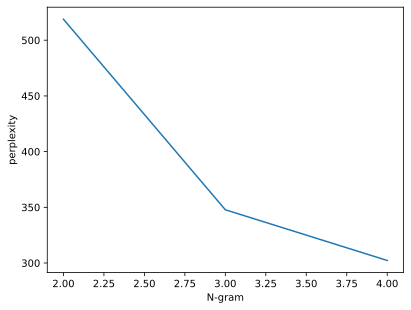

In [70]:
import matplotlib.pyplot as plt

perplexity = []
with open('.datasets/wikitext103_raw_test.sents.txt', 'r') as f:
    test_sents = f.readlines()
model_names = ['2-gram', '3-gram', '4-gram']
for model, model_name in zip([gram2_model, gram3_model, gram4_model], model_names):
    print(model_name, calculate_perplexity(test_sents, model))
    perplexity.append(calculate_perplexity(test_sents, model))

plt.plot([2, 3, 4],perplexity)
plt.xlabel('N-gram')
plt.ylabel('perplexity')

<a id="35"></a>
### 3.5 Generate sentences

- **Generate sentences from ngram LMs**

In [71]:
import re

def detok_wordpiece(sentence):
    """
    Merge WordPiece tokens: 'play', '##ing' -> 'playing'
    Keep punctuation tight-ish.
    """
    out = []
    tokens = sentence.split(" ")
    for t in tokens:
        if t.startswith("##") and out:
            out[-1] = out[-1] + t[2:]
        else:
            out.append(t)

    text = " ".join(out)

    # optional cleanup rules (lightweight)
    text = re.sub(r"\s+([.,!?;:%\)\]\}])", r"\1", text)   # remove space before punctuation
    text = re.sub(r"([\(\[\{])\s+", r"\1", text)          # remove space after opening bracket
    text = re.sub(r"\s+'", "'", text)                     # space before apostrophe
    text = re.sub(r"``\s*", '"', text)
    text = re.sub(r"\s*''", '"', text)
    return text
    
def ngram_generate(model, vocab, prompt, rand_seed, k, max_words):
    random.seed(rand_seed)
    sentence = ''
    state_in, state_out = kenlm.State(), kenlm.State()
    total_score = 0.0
    model.BeginSentenceWrite(state_in)
    selected_next_word = prompt
    count = 0
    while count < max_words:
        sentence += ' ' + selected_next_word
        sentence = sentence.strip()
        total_score += model.BaseScore(state_in, sentence, state_out)
        candidates = list((model.score(sentence + ' ' + next_word), next_word) for next_word in vocab)
        top_words = sorted(candidates, key=lambda item: item[0], reverse=True)
        selected_next_word = top_words[random.randint(0, k)][1]
        state_in, state_out = state_out, state_in
        count += 1
    return detok_wordpiece(sentence)

In [72]:
tok = Tokenizer.from_file(".datasets/wikitext103_bpe_tokenizer.json")
vocab = tok.get_vocab()   # dict: token -> id
print(len(vocab))
vocab = set([_[0] for _ in vocab.items()])

50000


In [74]:
import random

for n, model in zip([2, 3, 4], [gram2_model, gram3_model, gram4_model]):
    for i in range(3):
        sentence = ngram_generate(model, vocab, "He is", rand_seed=i*4 + n, k=50, max_words=50)
        print(f'{n}-gram: ', sentence)
    print('-'*40)

2-gram:  He is] = Week 15 pm guitar parts = 36 yards? equation " Donora? producer Dorney High Streets vocals spanning 13 pm that:. 09 ” / 4 [engineer! engineering design] − "! ¡ (H2O mixing elements 99 goals during
2-gram:  He is written – 07Faceo!. com named storms developed Batman War Machine; 55)] 3 − 36 oz –) 40 (46 [2 OT producer Frank — 42 rounds " that the [0 percent grade I feel] production assistant head
2-gram:  He is = " that — ‌. 01; 33 ′ 50 percent " Love — = (3264 Magazine: 10% share and piano solo recording labelmateus = 16 oz * 026 11 kg [t have to: 40. 088!
----------------------------------------
3-gram:  He is the angle bis: 23 women like “ that green crab.} 6 x OGames stated a new bass saxophone Award Association championships there and performer and judge. view this as) internal structure, guitar driven, piano works also helped transform Cá
3-gram:  He is usually not badlands, producer Robert Kelly and producer, actor Taylor: 12 = b + 5 = | +! engineer,? x ∗ engine

<a id="4"></a>
## 4. Build a Neural Probabilistic Language Model (NPLM)

### 4.1 backpropagation

The following followed from Adnrej's [micrograd](https://github.com/karpathy/micrograd).

In [12]:
def f(x):
    return 3 * x ** 2. - 4. * x + 5

In [13]:
x = 3.
print(f"evaluating f at x={x} : {f(x=x)}")

evaluating f at x=3.0 : 20.0


- **Draw the curve of f**

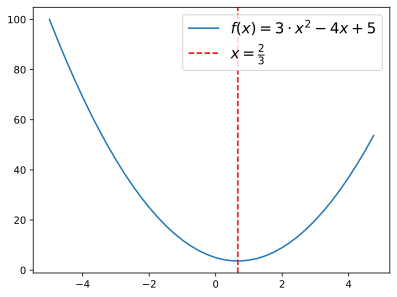

In [14]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys, label = r"$f(x) = 3 \cdot x^2 - 4 x + 5$")
plt.axvline(x=2/3, color='r', linestyle='--', label=r'$x = \frac{2}{3}$')
plt.legend(fontsize=15)

- What is the devaritive of $f(x)$ at any point $x$. Recall that
  $$
  f^\prime (x) = \lim_{h\rightarrow 0} \frac{ f(x + h ) - f(x)}{h}.
  $$
  We can approximate $f^\prime {x}$ by the following approximation:
  $$
  f^\prime (x) \approx \frac{ f(x + \delta_h ) - f(x)}{\delta_h}, \text{where } \delta_h \text{ is small.}
  $$

In [15]:
h = 0.000001
x = 2 / 3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [16]:
# Tokenization visualization
import tiktoken

cl100k_tokenizer = tiktoken.get_encoding("cl100k_base")

text = "Don't you love 🤗 Transformers? We sure do."
token_ids = cl100k_tokenizer.encode(text)
token_strs = [cl100k_tokenizer.decode([tid]) for tid in token_ids]
print("Original text:", text)
print("\nToken IDs:", token_ids)
print("\nToken strings:", token_strs)

Original text: Don't you love 🤗 Transformers? We sure do.

Token IDs: [8161, 956, 499, 3021, 11410, 97, 245, 81632, 30, 1226, 2771, 656, 13]

Token strings: ['Don', "'t", ' you', ' love', ' �', '�', '�', ' Transformers', '?', ' We', ' sure', ' do', '.']


<a id="5"></a>
## 5. References and Missing Lemmas

<a id="51"></a>
### 5.1 References

- https://cs229.stanford.edu/lectures-spring2023/cs229-probability_review.pdf
- https://cs229.stanford.edu/notes2022fall/main_notes.pdf
- https://anoopsarkar.github.io/nlp-class/assets/slides/prob.pdf
- https://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/lm.pdf
- https://pages.cs.wisc.edu/~jerryzhu/cs838/LM.pdf
- https://www3.nd.edu/~dchiang/teaching/nlp/2021/notes/chapter2v2.pdf
- https://www.fit.vut.cz/study/phd-thesis-file/283/283.pdf

<a id="52"></a>
### 5.2 Missing lemmas

<div style="
  background: rgba(0,0,0,0.05);
  border: 0px solid rgba(0,0,0,0.1);
  border-radius: 6px;
  padding: 15px 15px;
  line-height: 1.2;
">

Given a concave function $\varphi: \mathbb{R} \rightarrow \mathbb{R}$, and positive weights $a_{i}, i =1,2,\ldots,n$, Jensen's inequality can be stated as: $\varphi \left(\sum_{i=1}^n a_{i}x_{i} / \sum_{i=1}^n a_{i}\right) \geq \sum_{i=1}^n a_{i}\varphi (x_{i}) / \sum_{i=1}^n a_{i}$. That is, when $\varphi$ is concave and $a_i = 1$

$$n \cdot \varphi \left(\sum_{i=1}^n \frac {x_{i}}{n} \right) \geq \sum_{i=1}^n \varphi (x_{i}).$$

The following theorem states that when the probability distribution of random variable $X$ is uniform, the entropy of the random variable $X$ is maximized.

> **Theorem (Maximal entropy)**  
> Given a random variable $X$ and its probability distribution $p$, if $p$ is a uniform distribution, then the entropy of $X$ is maximized.

**Proof:**  
We can use Jensen's inequality to prove it. Let $\varphi( y) = - y \log (y)$ and we assume that $\varphi(0) = 0$ (This assumption does make sense). Assume further that random variable $X$ has $n$ possible outcomes, i.e., $x_1,x_2,\ldots, x_n$  with probability $p(x_1),p(x_2),\ldots, p(x_n)$. Since $\varphi(y)$ is concave on $[0,1]$ and $y_1 = p(x_1), y_2 = p(x_2),\ldots, y_n = p(x_n)$ are points in $[0,1]$, we have

$$\begin{align*}
n \cdot \varphi \left(\sum_{i=1}^n \frac {y_{i}}{n} \right) &\geq \sum_{i=1}^n \varphi (y_{i}) \\    
n \cdot \left( - \sum_{i=1}^n \frac {p(x_i)}{n}\right) \log \left(\sum_{i=1}^n \frac { p(x_i)}{n}\right) &\geq -\sum_{i=1}^n p(x_i) \log p(x_i) \\
n \cdot \left( - \frac{1}{n} \right) \log \left(\frac{1}{n} \right) &\geq -\sum_{i=1}^n p(x_i) \log p(x_i) := H(p),
\end{align*}$$

where the last inequality directly indicates $\log(n) \geq H(p)$. Clearly, the upper bound of the entropy $H(p)$ is attainable when $p(x_i)=1/n$ for all $i=1,2,\ldots,n$. We finish the proof.

One can find more on this topic in Conrad (2004).

    </div>